<font size="5"><center> **Exercise 3 (Music Transformer)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

#### Based on the 2019 ICLR paper by Cheng-Zhi Anna Huang, Google Brain, and Damon Gwinn's code/repo [GitHub](https://github.com/gwinndr/MusicTransformer-Pytorch)


###Setup Environment and Dependencies. Check GPU.

In [ ]:
#@title Check if GPU (driver) is avaiiable (you do not want to run this on CPU, trust me)
# !pip uninstall torch torchvision
# !pip install torch==1.11.0
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sun Apr 28 06:25:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  7

In [ ]:
#@title Clone/Install all dependencies
!git clone https://github.com/asigalov61/midi-neural-processor
!git clone https://github.com/asigalov61/MusicTransformer-Pytorch
!pip install tqdm
!pip install progress
!pip install pretty-midi
!pip install pypianoroll
!pip install matplotlib
!pip install librosa
!pip install scipy
!pip install pillow
!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio
!pip install mir_eval
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 /content/font.sf2

Cloning into 'midi-neural-processor'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Receiving objects: 100% (26/26), 8.00 KiB | 8.00 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Cloning into 'MusicTransformer-Pytorch'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 385 (delta 99), reused 84 (delta 84), pack-reused 247
Receiving objects: 100% (385/385), 100.31 KiB | 1006.00 KiB/s, done.
Resolving deltas: 100% (200/200), done.
  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9614 sha256=a710065c589b84d6d67ce6b207dde0c04ffb686c8344417e5746e9b119195c0e
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 43.8 MB/s eta 0:00:

In [ ]:
#@title Import all needed modules
import numpy as np
import pickle
import os
import sys
import math
import random
# For plotting
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
#%matplotlib inline
#matplotlib.get_backend()
import mir_eval.display
import librosa
import librosa.display
# For rendering output audio
import pretty_midi
from midi2audio import FluidSynth
from google.colab import output
from IPython.display import display, Javascript, HTML, Audio

In [ ]:
import shutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ==> the following two sf2 files should be in the drive
# ==> both of them are submitted
# Import soundfont for Maestro Dataset
piano_soundfont_path = '/content/drive/My Drive/piano.sf2'
piano_soundfont_destination_path = '/content/piano.sf2'
shutil.copyfile(piano_soundfont_path, piano_soundfont_destination_path)
# Import soundfort for Custom Dataset
# drums_soundfont_path = '/content/drive/My Drive/drums.sf2'
# drums_soundfont_destination_path = '/content/drums.sf2'
# shutil.copyfile(drums_soundfont_path, drums_soundfont_destination_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drums.sf2'

In [ ]:
#@title (Optional) Pre-trained models download (2 models trained for 100 epochs to 1.968 FLoss and 0.420 acc)
# !mkdir /content/MusicTransformer-Pytorch/rpr
# !mkdir /content/MusicTransformer-Pytorch/rpr/results
# %cd /content/MusicTransformer-Pytorch/rpr/results
# !wget 'https://superpiano.s3-us-west-1.amazonaws.com/SuperPiano3models.zip'
# !unzip SuperPiano3models.zip
# %cd /content/MusicTransformer-Pytorch/

---

#Option 1: MAESTRO DataSet

In [ ]:
#@title Download Google Magenta MAESTRO v.2.0.0 Piano MIDI Dataset (~1300 MIDIs)
%cd /content/MusicTransformer-Pytorch/dataset/
!wget 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'
!unzip maestro-v2.0.0-midi.zip
%cd /content/MusicTransformer-Pytorch/

/content/MusicTransformer-Pytorch/dataset
--2024-04-28 06:29:55--  https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.207, 74.125.23.207, 74.125.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59243107 (56M) [application/zip]
Saving to: ‘maestro-v2.0.0-midi.zip’

maestro-v2.0.0-midi 100%[===================>]  56.50M  20.6MB/s    in 2.7s    

2024-04-28 06:29:58 (20.6 MB/s) - ‘maestro-v2.0.0-midi.zip’ saved [59243107/59243107]

Archive:  maestro-v2.0.0-midi.zip
   creating: maestro-v2.0.0/
  inflating: maestro-v2.0.0/maestro-v2.0.0.csv  
   creating: maestro-v2.0.0/2008/
  inflating: maestro-v2.0.0/2008/MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--1.midi  
  inflating: maestro-v2.0.0/2008/MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_0

In [ ]:
#@title Prepare directory sctructure and MIDI processor
%cd /content/
!mv midi-neural-processor midi_processor
%cd /content/MusicTransformer-Pytorch/

/content
/content/MusicTransformer-Pytorch


In [ ]:
#@title Process MAESTRO MIDI DataSet
!python3 preprocess_midi.py '/content/MusicTransformer-Pytorch/dataset/maestro-v2.0.0'

Preprocessing midi files and saving to ./dataset/e_piano
Found 1282 pieces
Preprocessing...
50 / 1282
100 / 1282
150 / 1282
200 / 1282
250 / 1282
300 / 1282
350 / 1282
400 / 1282
450 / 1282
500 / 1282
550 / 1282
600 / 1282
650 / 1282
700 / 1282
750 / 1282
800 / 1282
850 / 1282
900 / 1282
950 / 1282
1000 / 1282
1050 / 1282
1100 / 1282
1150 / 1282
1200 / 1282
1250 / 1282
Num Train: 967
Num Val: 137
Num Test: 178
Done!



#Train the Model

In [ ]:
#@title Activate Tensorboard Graphs/Stats to monitor/evaluate model perfomance during and after training runs
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime, os
%tensorboard --logdir /content/MusicTransformer-Pytorch/rpr

In [ ]:
!pip install torch==1.11.0
# !pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.11.0 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.


In [ ]:
#@title Start to Train the Model
batch_size = 3 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 10 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
!python3 train.py -output_dir rpr --rpr -batch_size=$batch_size -epochs=$number_of_training_epochs -max_sequence=$maximum_output_MIDI_sequence #-n_layers -num_heads -d_model -dim_feedforward

Streaming output truncated to the last 5000 lines.
Epoch 9  Batch 25 / 323
LR: 0.00045577354322632436
Train loss: 2.775355577468872

Time (s): 0.7917835712432861

Epoch 9  Batch 26 / 323
LR: 0.0004559482360370665
Train loss: 2.8110411167144775

Time (s): 0.7969832420349121

Epoch 9  Batch 27 / 323
LR: 0.00045612292884780867
Train loss: 2.9136922359466553

Time (s): 0.7961032390594482

Epoch 9  Batch 28 / 323
LR: 0.00045629762165855085
Train loss: 2.9122378826141357

Time (s): 0.7959415912628174

Epoch 9  Batch 29 / 323
LR: 0.00045647231446929303
Train loss: 2.948295831680298

Time (s): 0.7973332405090332

Epoch 9  Batch 30 / 323
LR: 0.0004566470072800352
Train loss: 3.0714428424835205

Time (s): 0.798633337020874

Epoch 9  Batch 31 / 323
LR: 0.00045682170009077734
Train loss: 3.011211395263672

Time (s): 0.8002991676330566

Epoch 9  Batch 32 / 323
LR: 0.0004569963929015195
Train loss: 2.904611587524414

Time (s): 0.8081552982330322

Epoch 9  Batch 33 / 323
LR: 0.0004571710857122617
Tra

In [ ]:
#@title Re-Start Training from a certain checkpoint and epoch
batch_size = 4 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 102 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
saved_checkpoint_full_path = "/content/MusicTransformer-Pytorch/rpr/weights/epoch_0033.pickle" #@param {type:"string"}
continue_epoch_number = 33 #@param {type:"integer"}

!python3 train.py -output_dir rpr --rpr -batch_size=$batch_size -epochs=$number_of_training_epochs -max_sequence=$maximum_output_MIDI_sequence -continue_weights $saved_checkpoint_full_path -continue_epoch $continue_epoch_number #-n_layers -num_heads -d_model -dim_feedforward

###Evaluate the resulted models

In [ ]:
#@title Evaluate Best Resulting Accuracy Model (best_acc_weights.pickle)
!python3 evaluate.py -model_weights rpr/results/best_acc_weights.pickle --rpr

dataset_dir: ./dataset/e_piano
model_weights: rpr/results/best_acc_weights.pickle
n_workers: 1
force_cpu: False

batch_size: 2

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

Evaluating:
Avg loss: 2.672972544034322
Avg acc: 0.2897110614511702



In [ ]:
#@title Evaluate Best Resulting Loss Model (best_loss_weights.pickle)
!python3 evaluate.py -model_weights rpr/results/best_loss_weights.pickle --rpr

dataset_dir: ./dataset/e_piano
model_weights: rpr/results/best_loss_weights.pickle
n_workers: 1
force_cpu: False

batch_size: 2

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

Evaluating:
Avg loss: 2.6577585379282636
Avg acc: 0.29212039791875416



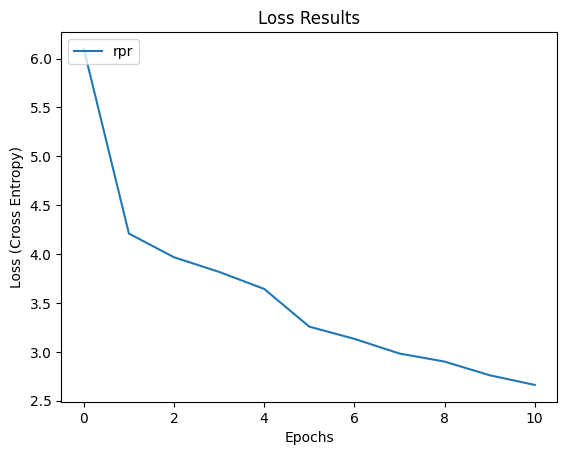

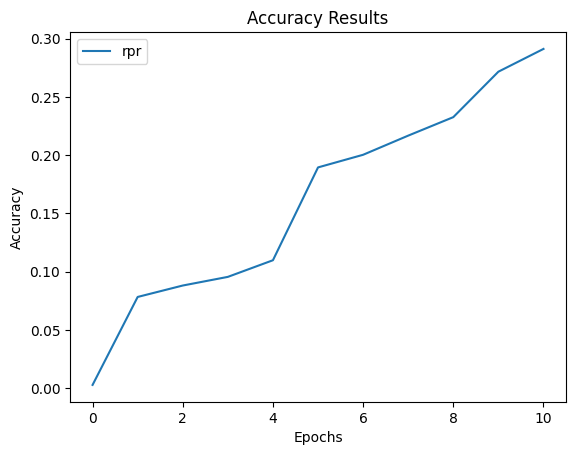

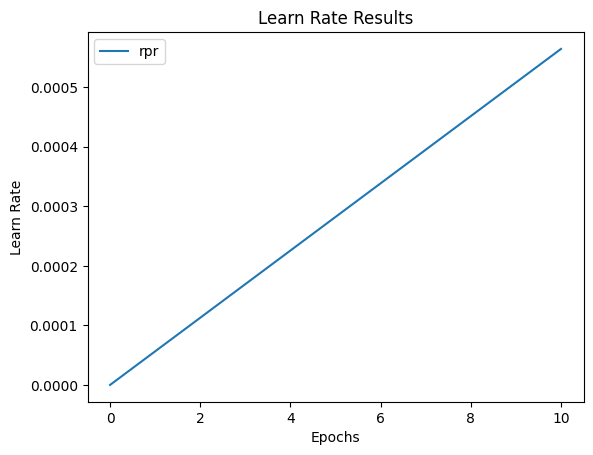

In [ ]:
#@title Graph the results
import argparse
import os
import csv
import math
import matplotlib.pyplot as plt

RESULTS_FILE = "results.csv"
EPOCH_IDX = 0
LR_IDX = 1
EVAL_LOSS_IDX = 4
EVAL_ACC_IDX = 5

SPLITTER = '?'


def graph_results(input_dirs="/content/MusicTransformer-Pytorch/rpr/results", output_dir=None, model_names=None, epoch_start=0, epoch_end=None):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Graphs model training and evaluation data
    ----------
    """

    input_dirs = input_dirs.split(SPLITTER)

    if(model_names is not None):
        model_names = model_names.split(SPLITTER)
        if(len(model_names) != len(input_dirs)):
            print("Error: len(model_names) != len(input_dirs)")
            return

    #Initialize Loss and Accuracy arrays
    loss_arrs = []
    accuracy_arrs = []
    epoch_counts = []
    lrs = []

    for input_dir in input_dirs:
        loss_arr = []
        accuracy_arr = []
        epoch_count = []
        lr_arr = []

        f = os.path.join(input_dir, RESULTS_FILE)
        with open(f, "r") as i_stream:
            reader = csv.reader(i_stream)
            next(reader)

            lines = [line for line in reader]

        if(epoch_end is None):
            epoch_end = math.inf

        epoch_start = max(epoch_start, 0)
        epoch_start = min(epoch_start, epoch_end)

        for line in lines:
            epoch = line[EPOCH_IDX]
            lr = line[LR_IDX]
            accuracy = line[EVAL_ACC_IDX]
            loss = line[EVAL_LOSS_IDX]

            if(int(epoch) >= epoch_start and int(epoch) < epoch_end):
                accuracy_arr.append(float(accuracy))
                loss_arr.append(float(loss))
                epoch_count.append(int(epoch))
                lr_arr.append(float(lr))

        loss_arrs.append(loss_arr)
        accuracy_arrs.append(accuracy_arr)
        epoch_counts.append(epoch_count)
        lrs.append(lr_arr)

    if(output_dir is not None):
        try:
            os.mkdir(output_dir)
        except OSError:
            print ("Creation of the directory %s failed" % output_dir)
        else:
            print ("Successfully created the directory %s" % output_dir)

    ##### LOSS #####
    for i in range(len(loss_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], loss_arrs[i], label=name)
        plt.title("Loss Results")
        plt.ylabel('Loss (Cross Entropy)')
        plt.xlabel('Epochs')
        fig1 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig1.savefig(os.path.join(output_dir, 'loss_graph.png'))

    plt.show()

    ##### ACCURACY #####
    for i in range(len(accuracy_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], accuracy_arrs[i], label=name)
        plt.title("Accuracy Results")
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'accuracy_graph.png'))

    plt.show()

    ##### LR #####
    for i in range(len(lrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], lrs[i], label=name)
        plt.title("Learn Rate Results")
        plt.ylabel('Learn Rate')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'lr_graph.png'))

    plt.show()
graph_results('/content/MusicTransformer-Pytorch/rpr/results', model_names='rpr')

To have the model continue your custom MIDI enter the following into the custom_MIDI field below:

-primer_file '/content/some_dir/some_seed_midi.mid'

For example: -primer_file '/content/MusicTransformer-Pytorch/seed.mid'

# Generate and Explore the output :)

#### !!! Change the sound font in the following code cell to produce different sounding .wav files. I provide piano.sf2 (by default font.sf2 is piano as well) and drums.sf2 for custom drum dataset that i provide in mega file as well !!!

In [ ]:
#@title Generate, Plot, Graph, Save, Download, and Render the resulting output
number_of_tokens_to_generate = 1023 #@param {type:"slider", min:1, max:2048, step:1}
priming_sequence_length = 65 #@param {type:"slider", min:1, max:2048, step:8}
maximum_possible_output_sequence = 2048 #@param {type:"slider", min:0, max:2048, step:8}
select_model = "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle" #@param ["/content/MusicTransformer-Pytorch/rpr/results/best_acc_weights.pickle", "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle"]
custom_MIDI = "" #@param {type:"string"}

import processor
from processor import encode_midi, decode_midi

!python generate.py -output_dir output -model_weights=$select_model --rpr -target_seq_length=$number_of_tokens_to_generate -num_prime=$priming_sequence_length -max_sequence=$maximum_possible_output_sequence $custom_MIDI #

print('Successfully exported the output to output folder. To primer.mid and rand.mid')

# set the src and play
FluidSynth("/content/piano.sf2").midi_to_audio('/content/MusicTransformer-Pytorch/output/rand.mid', '/content/MusicTransformer-Pytorch/output/output.wav')

from google.colab import files
files.download('/content/MusicTransformer-Pytorch/output/rand.mid')
files.download('/content/MusicTransformer-Pytorch/output/primer.mid')

Audio('/content/MusicTransformer-Pytorch/output/output.wav')


midi_root: ./dataset/e_piano/
output_dir: output
primer_file: None
force_cpu: False

target_seq_length: 1023
num_prime: 65
model_weights: /content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle
beam: 0

rpr: True
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

Using primer index: 98 ( ./dataset/e_piano/test/MIDI-Unprocessed_15_R1_2006_01-05_ORIG_MID--AUDIO_15_R1_2006_02_Track02_wav.midi.pickle )
RAND DIST
Generating sequence of max length: 1023
100 / 1023
150 / 1023
200 / 1023
250 / 1023
300 / 1023
350 / 1023
400 / 1023
450 / 1023
500 / 1023
550 / 1023
600 / 1023
650 / 1023
700 / 1023
750 / 1023
800 / 1023
850 / 1023
900 / 1023
950 / 1023
1000 / 1023
info removed pitch: 62
info removed pitch: 30
info removed pitch: 34
info removed pitch: 70
info removed pitch: 73
info removed pitch: 47
info removed pitch: 43
info removed pitch: 90
info removed pitch: 79
info removed pitch: 70
info removed pitch: 79
info removed pitch: 101
info removed pit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>